# Цель исследования: 
разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Ход работы
  
Шаг 1. Загрузка данных

Шаг 2. Предобработка данных

Шаг 3. Исследовательский анализ данных

Шаг 4. Объединение таблиц

Шаг 5. Корреляционный анализ

Шаг 6. Использование пайплайнов

Шаг 7. Анализ важности признаков

Шаг 8. Сегментация покупателей

Шаг 9. Общий вывод

### Загрузка Данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score
)
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm
!pip install shap
!pip install shap==0.42.0 -q
import shap
!pip install phik
import numpy as np
import seaborn as sn
from phik.report import plot_correlation_matrix
from phik import report
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

## Описание данных

In [2]:
data_market_file = pd.read_csv('/datasets/market_file.csv')
data_market_money = pd.read_csv('/datasets/market_money.csv')
data_market_time = pd.read_csv('/datasets/market_time.csv')
data_money = pd.read_csv('/datasets/money.csv')

#### market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

 - id — номер покупателя в корпоративной базе данных.

 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    
 
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. 
Согласие на это даёт покупатель.

 - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, 
которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, 
звонков, показов рекламы и прочего приходилось на клиента.

 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение 
последнего месяца.

 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [3]:
for i in [data_market_file]:
    display(i.head())
    display(i.info())
    print('Количество дубликатов:', i.duplicated().sum())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

Количество дубликатов: 0


In [4]:
# убиваем опечатку
data_market_file['Тип сервиса'].replace({'стандартт': 'стандарт'}, inplace=True)
data_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


##### market_money.csv

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

 - id — номер покупателя в корпоративной базе данных.
    
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

 - Выручка — сумма выручки за период.

In [5]:
for i in [data_market_money]:
    display(i.head())
    display(i.info())
    print('Количество дубликатов:', i.duplicated().sum())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Количество дубликатов: 0


##### market_time.csv

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

 - id — номер покупателя в корпоративной базе данных.
    
 - Период — название периода, во время которого зафиксировано общее время.

 - минут — значение времени, проведённого на сайте, в минутах.

In [6]:
for i in [data_market_time]:
    display(i.head())
    display(i.info())
    print('Количество дубликатов:', i.duplicated().sum())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Количество дубликатов: 0


In [7]:
# Выведем словарь, где ключ -> название столбца, а значение -> список уникальных значений столбца
[{i: data_market_time[i].unique()} for i in data_market_time.columns if data_market_time[i].dtype == 'object']

[{'Период': array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)}]

In [8]:
# Заменяем значения
data_market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'}, inplace=True)
data_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


##### money.csv

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

 - id — номер покупателя в корпоративной базе данных.
 
 - Прибыль — значение прибыли.

In [9]:
for i in [data_money]:
    display(i.head())
    display(i.info())
    print('Количество дубликатов:', i.duplicated().sum())

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


None

Количество дубликатов: 1209


In [10]:
# тут есть небольшая проблема с разделителями- меняем

data_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
display('Количество дубликатов:', data_money.duplicated().sum()) # после замены разделителей стоит еще раз проверить
data_money.head()

'Количество дубликатов:'

0

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [11]:
# Приводим к змеиному языку
for i in [data_market_file, data_market_money, data_market_time, data_money]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values]

In [12]:
# Проверяем
for i in [data_market_file, data_market_money, data_market_time, data_money]:
    display(i.head(1))

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


,id,период,выручка
0,215348,препредыдущий_месяц,0.0


,id,период,минут
0,215348,текущий_месяц,14


,id,прибыль
0,215348,0.98


В данном блоке была выполнена предобработка данных: удалены опечатки, все названия столбцов приведены к единообразию, поправлены разделители, убраны заглавные буквы. 
Дубликатов не обнаружено

## Исследовательский анализ

In [13]:
# Посмотрим что с активностью
frequency = data_market_file['покупательская_активность'].value_counts(normalize=True)
frequency

Прежний уровень    0.616923
Снизилась          0.383077
Name: покупательская_активность, dtype: float64

In [14]:
data_market_money.groupby(['id', 'период'], as_index=False).agg({'выручка': 'sum'}).head()

,id,период,выручка
0,215348,предыдущий_месяц,0.0
1,215348,препредыдущий_месяц,0.0
2,215348,текущий_месяц,3293.1
3,215349,предыдущий_месяц,5216.0
4,215349,препредыдущий_месяц,4472.0


Видно что есть строки где выручка по нулям

In [15]:
data_market_money.loc[data_market_money['выручка']==0]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [16]:
# Убираем тех, кто не приносил дохода за три месяца
id_nul = [215348, 215357, 215359]
data_market_file_ok = data_market_file.query('id not in [215348, 215357, 215359]')
data_market_money_ok = data_market_money.query('id not in [215348, 215357, 215359]')
data_market_time_ok = data_market_time.query('id not in [215348, 215357, 215359]')
data_money_ok = data_money.query('id not in [215348, 215357, 215359]')

display(data_market_file_ok['id'].nunique())
display(data_market_money_ok['id'].nunique())
display(data_market_time_ok['id'].nunique())
display(data_money_ok['id'].nunique())

1297

1297

1297

1297

In [17]:
# сГотовим к объединению
data_market_file_ok['id'][~data_market_file_ok['id'].isin(data_market_money_ok['id'])]

Series([], Name: id, dtype: int64)

In [18]:
data_market_file_ok['id'][~data_market_file_ok['id'].isin(data_market_time_ok['id'])]

Series([], Name: id, dtype: int64)

In [19]:
data_market_file_ok['id'][~data_market_file_ok['id'].isin(data_money_ok['id'])]

Series([], Name: id, dtype: int64)

In [20]:
data_market_file_ok = data_market_file_ok.set_index('id')

In [21]:
data_market_money_ok = data_market_money_ok.set_index('id')

In [22]:
data_market_money_ok = data_market_money_ok.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')

In [23]:
# Объединяем и переименовываем столбцы
df_full = data_market_file_ok.join(data_market_money_ok)

In [24]:
df_full.rename(columns={
    'предыдущий_месяц': 'выручка_предыдущий_мес',
    'препредыдущий_месяц': 'выручка_препредыдущий_мес',
    'текущий_месяц': 'выручка_текущий_мес'}, inplace=True)


In [25]:
display(df_full.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес
id,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5


In [26]:
data_market_time_ok = data_market_time_ok.pivot_table(index='id', columns='период', values='минут', aggfunc='sum')

In [27]:
df_full = df_full.join(data_market_time_ok)

In [28]:
df_full.rename(columns={
    'предыдущий_месяц': 'min_предыдущий_мес',
    'текущий_месяц': 'min_текущий_мес'}, inplace=True)

In [29]:
display(df_full.head())

df_full.dropna()
df_full.shape

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес,min_предыдущий_мес,min_текущий_мес
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


(1297, 17)

Теперь рассмотрим подробнее данные, которые представлены в общей таблице:

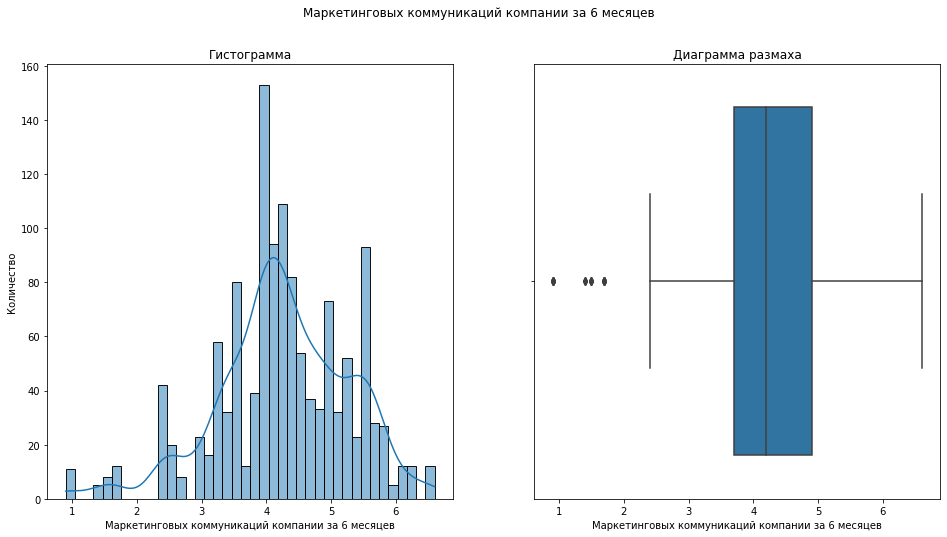

In [30]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'маркет_актив_6_мес', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Маркетинговых коммуникаций компании за 6 месяцев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'маркет_актив_6_мес', ax=axs[1])
axs[1].set_xlabel('Маркетинговых коммуникаций компании за 6 месяцев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Маркетинговых коммуникаций компании за 6 месяцев')
plt.show()

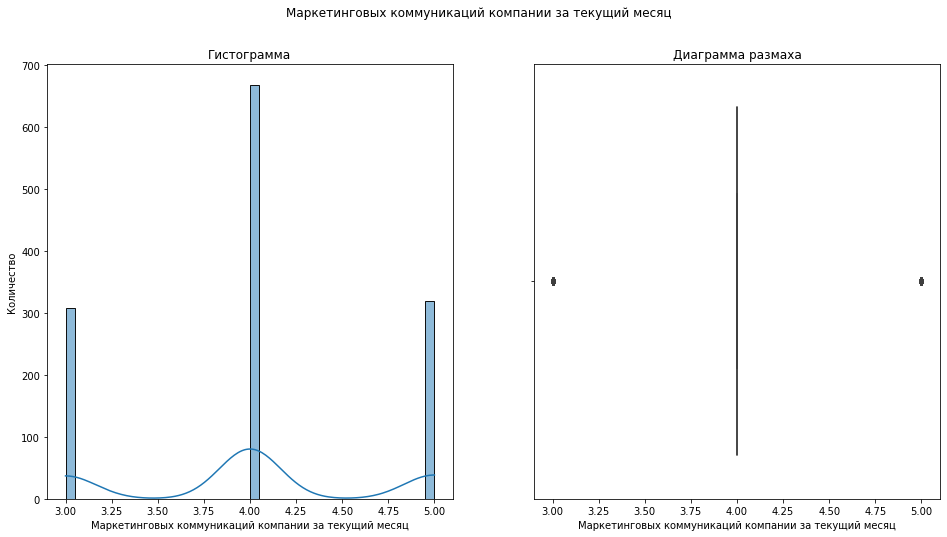

In [31]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'маркет_актив_тек_мес', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Маркетинговых коммуникаций компании за текущий месяц')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'маркет_актив_тек_мес', ax=axs[1])
axs[1].set_xlabel('Маркетинговых коммуникаций компании за текущий месяц')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Маркетинговых коммуникаций компании за текущий месяц')
plt.show()

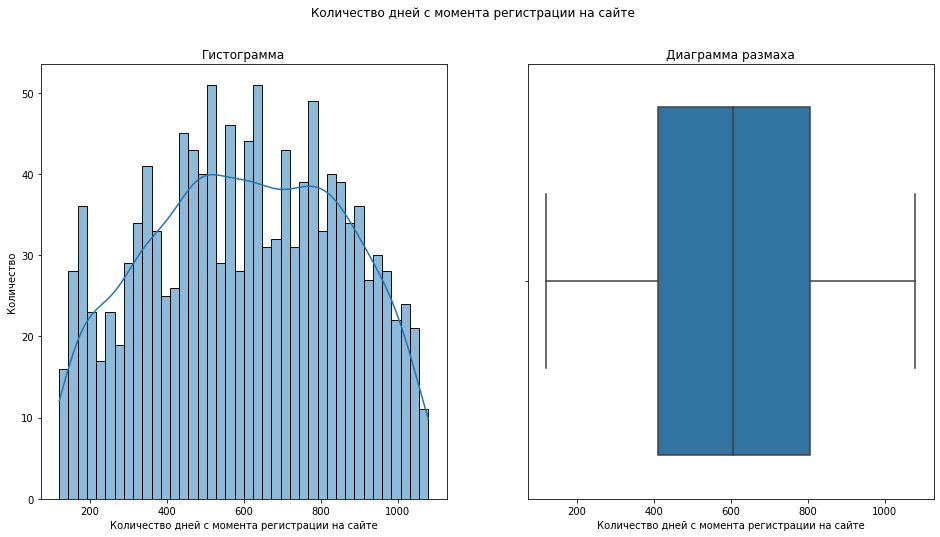

In [32]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'длительность', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Количество дней с момента регистрации на сайте')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'длительность', ax=axs[1])
axs[1].set_xlabel('Количество дней с момента регистрации на сайте')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Количество дней с момента регистрации на сайте')
plt.show()

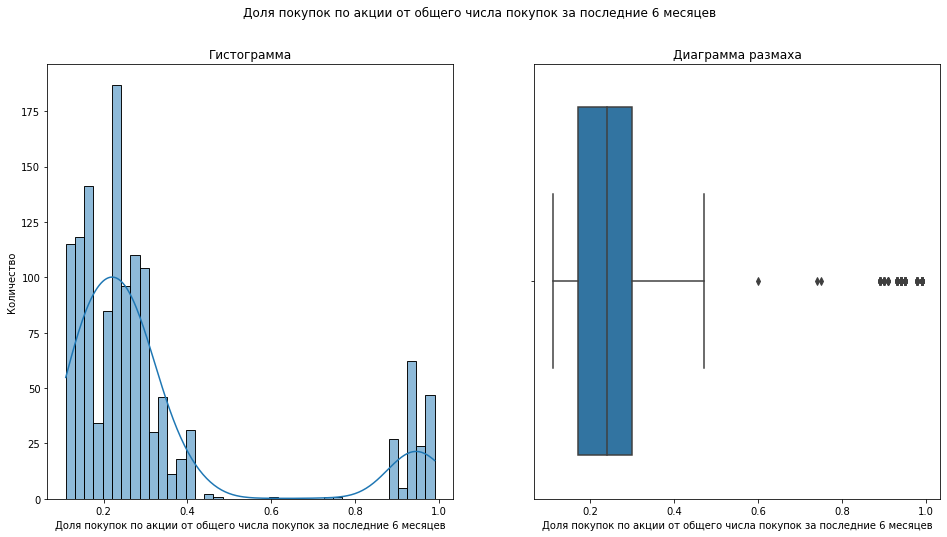

In [33]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'акционные_покупки', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'акционные_покупки', ax=axs[1])
axs[1].set_xlabel('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.show()

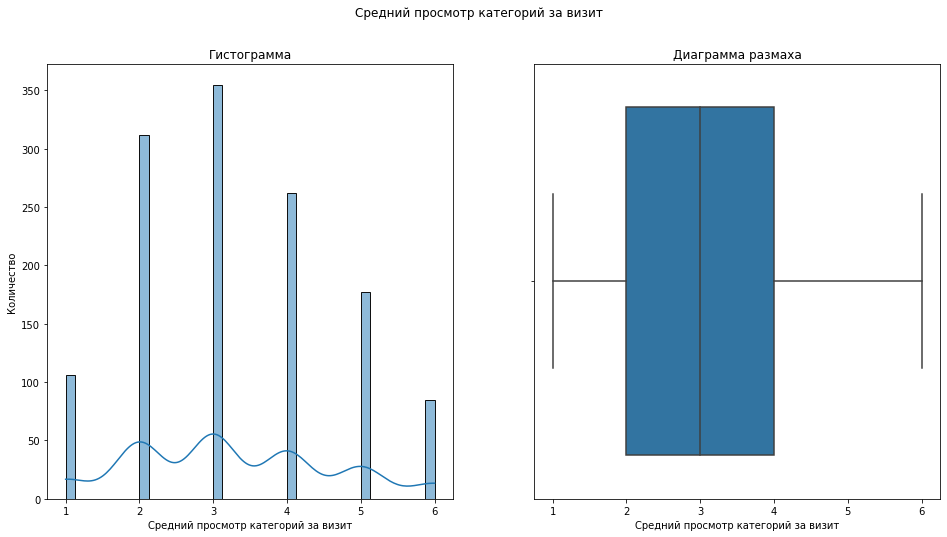

In [34]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'средний_просмотр_категорий_за_визит', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Средний просмотр категорий за визит')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'средний_просмотр_категорий_за_визит', ax=axs[1])
axs[1].set_xlabel('Средний просмотр категорий за визит')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Средний просмотр категорий за визит')
plt.show()

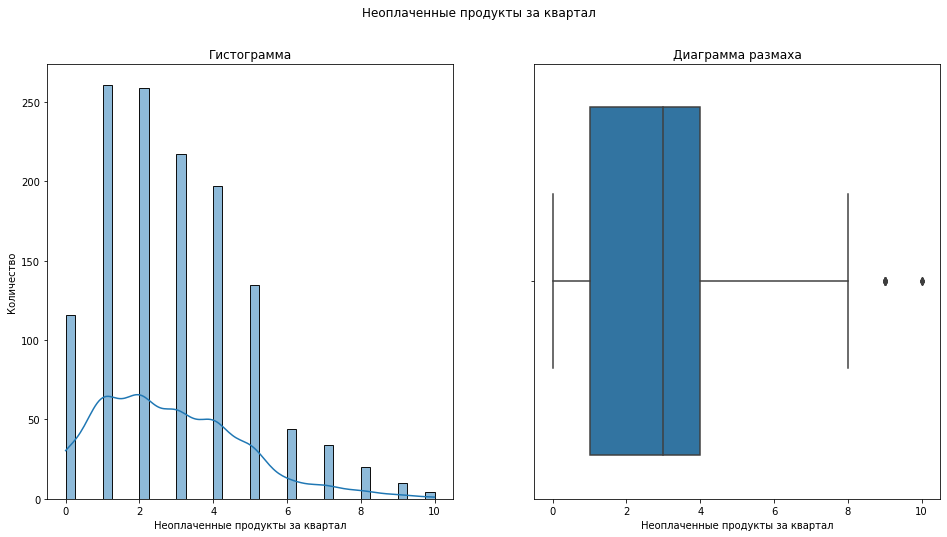

In [35]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'неоплаченные_продукты_штук_квартал', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Неоплаченные продукты за квартал')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'неоплаченные_продукты_штук_квартал', ax=axs[1])
axs[1].set_xlabel('Неоплаченные продукты за квартал')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Неоплаченные продукты за квартал')
plt.show()

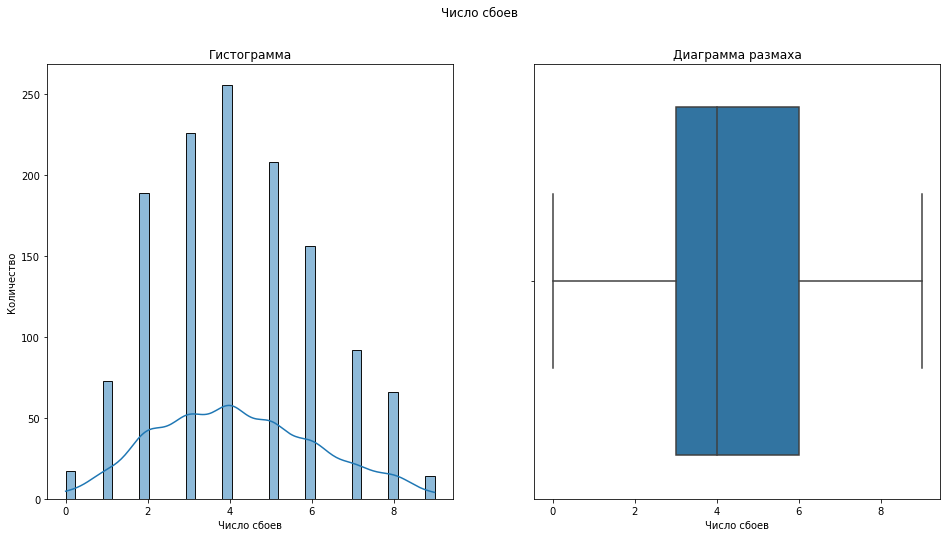

In [36]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'ошибка_сервиса', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Число сбоев')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'ошибка_сервиса', ax=axs[1])
axs[1].set_xlabel('Число сбоев')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Число сбоев')
plt.show()

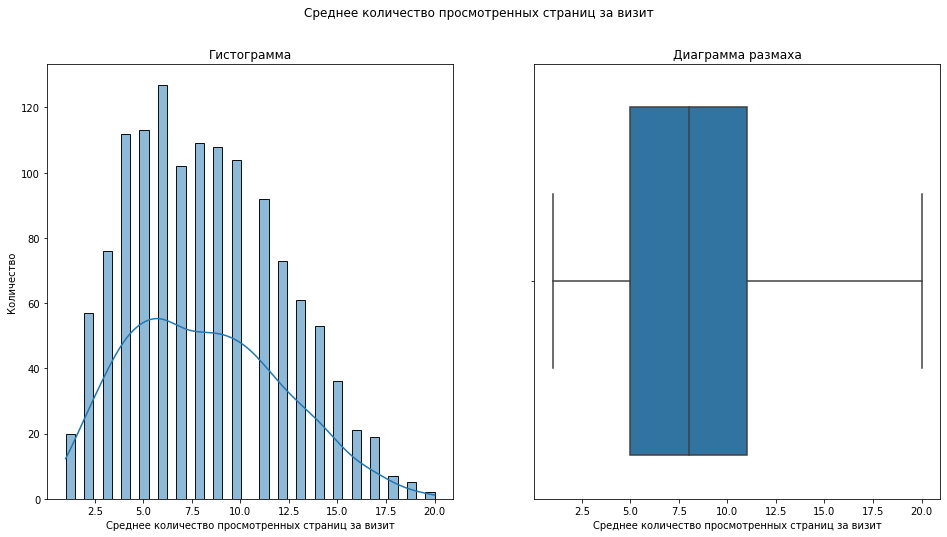

In [37]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_file_ok,x = 'страниц_за_визит', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Среднее количество просмотренных страниц за визит')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_file_ok,x = 'страниц_за_визит', ax=axs[1])
axs[1].set_xlabel('Среднее количество просмотренных страниц за визит')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Среднее количество просмотренных страниц за визит')
plt.show()

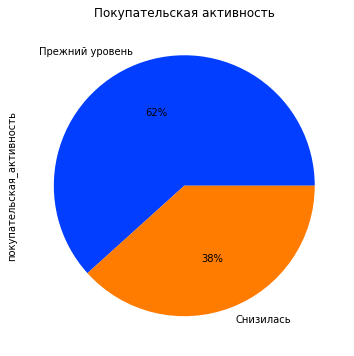

In [38]:
palette_color = sn.color_palette('bright') 
data_market_file['покупательская_активность'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Покупательская активность', colors = palette_color, figsize = (10, 6))
plt.show()

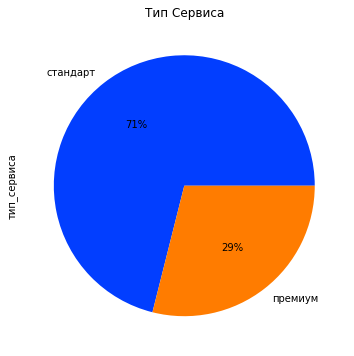

In [39]:
palette_color = sn.color_palette('bright') 
data_market_file['тип_сервиса'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тип Сервиса', colors = palette_color, figsize = (10, 6))
plt.show()

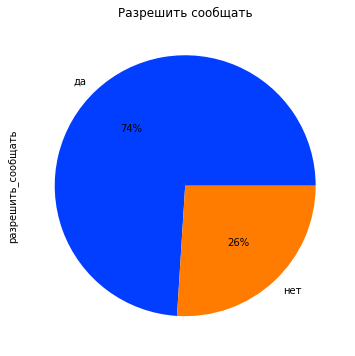

In [40]:
palette_color = sn.color_palette('bright') 
data_market_file['разрешить_сообщать'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Разрешить сообщать', colors = palette_color, figsize = (10, 6))
plt.show()

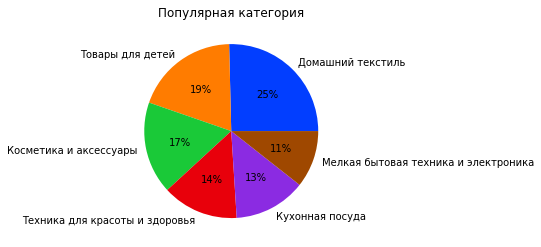

In [41]:
palette_color = sn.color_palette('bright') 
plt.pie(data_market_file['популярная_категория'].value_counts(), autopct='%1.0f%%', labels=['Домашний текстиль', 'Товары для детей', 'Косметика и аксессуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника'], colors = palette_color)
plt.title('Популярная категория')
plt.show()

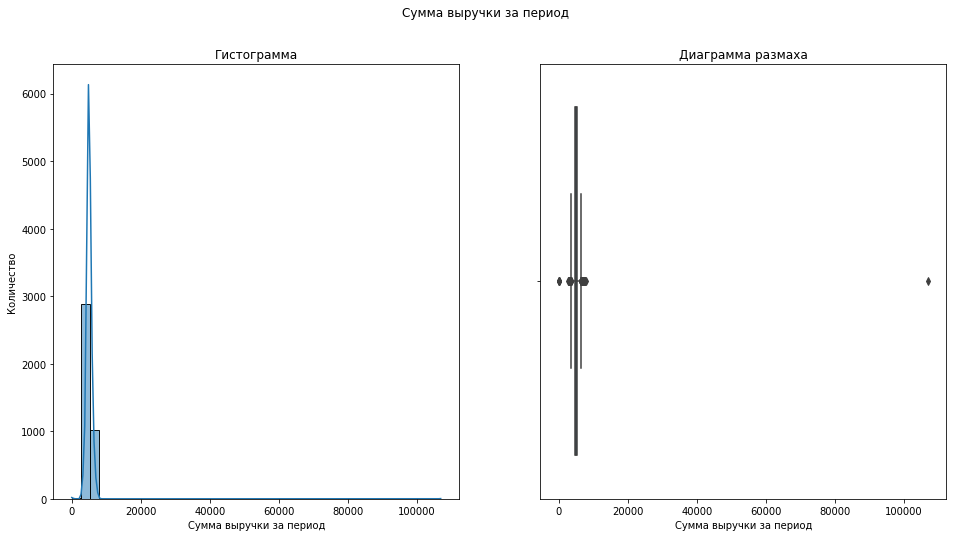

In [42]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_money,x = 'выручка', ax=axs[0], bins = 40, kde = True)
axs[0].set_xlabel('Cумма выручки за период')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_money,x = 'выручка', ax=axs[1])
axs[1].set_xlabel('Cумма выручки за период')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Cумма выручки за период')
plt.show()

In [43]:
data_market_money_ok.describe()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1297.000000,1297.000000,1297.000000
mean,4948.339630,4836.367772,5316.449268
std,701.228571,333.438742,2942.469139
min,2890.000000,4098.000000,2758.700000
25%,4498.500000,4585.000000,4706.600000
50%,5005.500000,4812.000000,5180.300000
75%,5409.000000,5055.000000,5761.300000
max,6869.500000,5663.000000,106862.200000


Тут есть аномально большое значение- удалим.


In [44]:
data_market_money = data_market_money.query('выручка < 20000')

In [45]:
data_market_money_ok.describe()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1297.000000,1297.000000,1297.000000
mean,4948.339630,4836.367772,5316.449268
std,701.228571,333.438742,2942.469139
min,2890.000000,4098.000000,2758.700000
25%,4498.500000,4585.000000,4706.600000
50%,5005.500000,4812.000000,5180.300000
75%,5409.000000,5055.000000,5761.300000
max,6869.500000,5663.000000,106862.200000


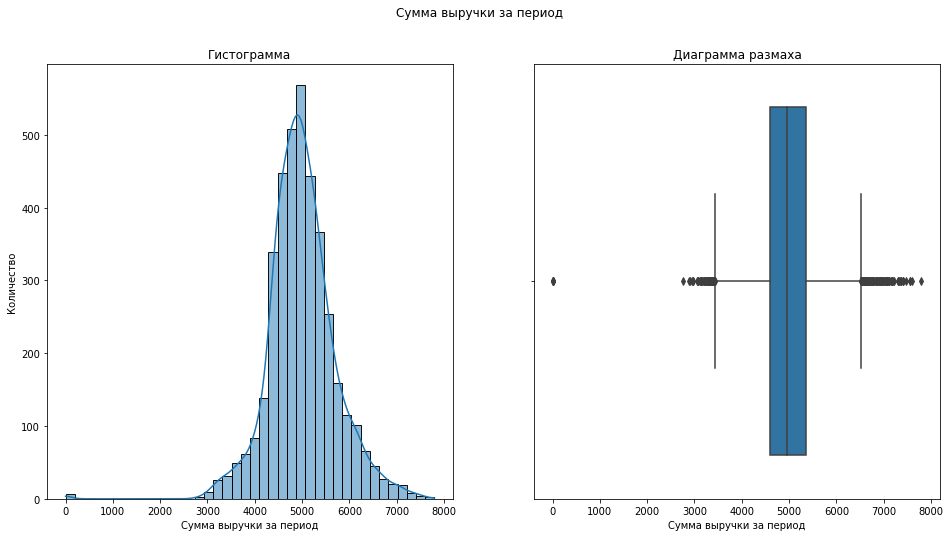

In [46]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_money,x = 'выручка', ax=axs[0], bins = 40, kde = True)
axs[0].set_xlabel('Cумма выручки за период')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_money,x = 'выручка', ax=axs[1])
axs[1].set_xlabel('Cумма выручки за период')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Cумма выручки за период')
plt.show()

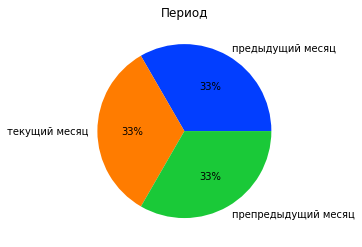

In [47]:
palette_color = sn.color_palette('bright') 
plt.pie(data_market_money['период'].value_counts(), autopct='%1.0f%%', labels=['предыдущий месяц', 'текущий месяц', 'препредыдущий месяц'], colors = palette_color)
plt.title('Период')
plt.show()

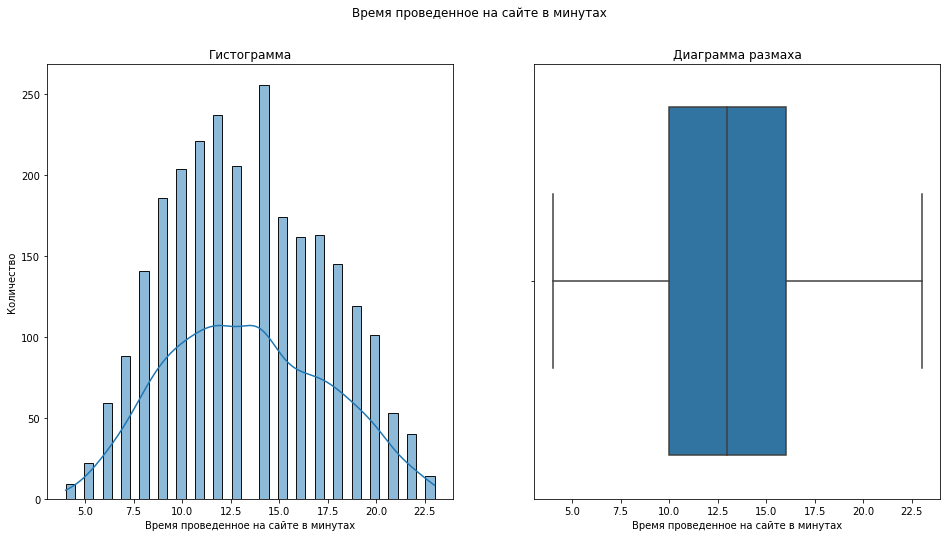

In [48]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_market_time, x = 'минут', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Время проведенное на сайте в минутах')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_market_time,x = 'минут', ax=axs[1])
axs[1].set_xlabel('Время проведенное на сайте в минутах')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Время проведенное на сайте в минутах')
plt.show()

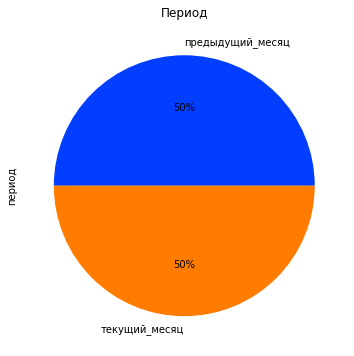

In [49]:
palette_color = sn.color_palette('bright') 
data_market_time['период'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Период', colors = palette_color, figsize = (10, 6))
plt.show()

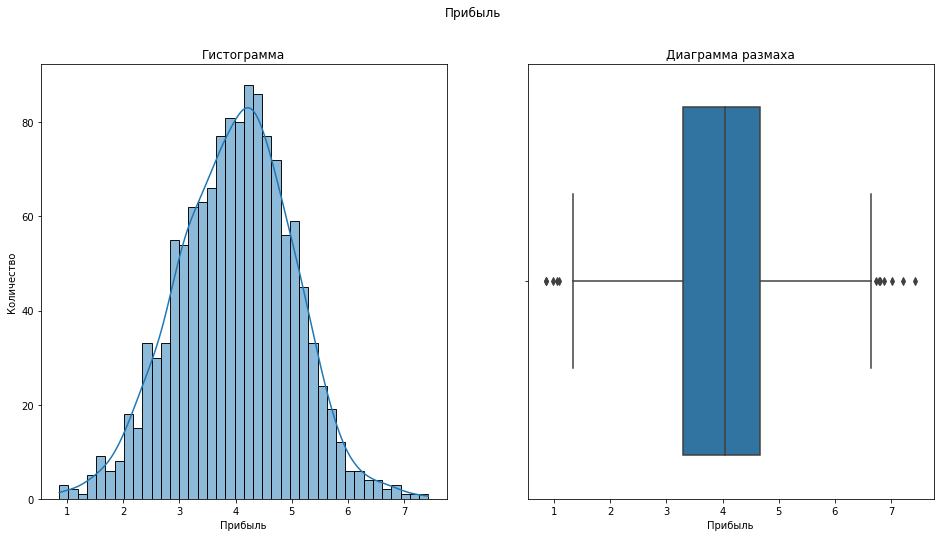

In [50]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data_money,x = 'прибыль', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Прибыль')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data_money,x = 'прибыль', ax=axs[1])
axs[1].set_xlabel('Прибыль')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Прибыль')
plt.show()

In [51]:
# так как сначала я объединила таблицу, а потом нашла выброс, нужно убрать его и из таблицы

df_full = df_full.query('выручка_текущий_мес < 20000')
df_full = df_full.query('выручка_препредыдущий_мес < 20000')
df_full = df_full.query('выручка_предыдущий_мес < 20000')

In [52]:
df_full.shape

(1296, 17)

## Корелляционный анализ

In [53]:
df_full.phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_мес', 'выручка_препредыдущий_мес', 'выручка_текущий_мес', 'min_предыдущий_мес', 'min_текущий_мес']


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес,min_предыдущий_мес,min_текущий_мес
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


Признаки выручка_текущий_месяц и выручка_предыдущий_месяц - мультиколлинеарны. Однако, мультиколлинеарность не с целевым признаком,  и не превышает значение 0.9, да и есть модели, которые к ней не чувствительны, так что оставим всё, как есть

## Пайплайны

In [54]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'выручка_препредыдущий_мес','выручка_предыдущий_мес','выручка_текущий_мес' ,
               'min_предыдущий_мес', 'min_текущий_мес']
RANDOM_STATE = 42

y = df_full['покупательская_активность']
X = df_full.drop(['покупательская_активность'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
)

In [55]:
label_encoder = LabelEncoder()

In [56]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [57]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse =False)
        )
    ]
)

In [58]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [60]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [61]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(13, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord'...
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Метрика Roc-auc была выбрана потому что она устойчива к несбалансированным классам и не зависит от порога классификации

In [63]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most...
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_препредыдущий_мес',
                                                   'выручка_предыдущий_мес',
                                                   'выручка_текущий_мес',
                                                   'min_предыдущий_мес',
                                                   'min_текущий_мес'])])),
                ('models', KNeighborsClassifier(n_neighbors=17))])

In [64]:
randomized_search.best_score_

0.8653842317354148

In [65]:
y_predict = randomized_search.predict(X_test)
y_predict_proba = randomized_search.predict_proba(X_test)

In [66]:
roc_auc_score(y_test, y_predict_proba[:, 1])

0.900012025012025

In [67]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.900012025012025


Лучшая модель: KNeighborsClassifier(n_neighbors=17), значение roc_auc -0.9

# Анализ важности признаков

Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP

In [68]:
best_model = randomized_search.best_estimator_

In [69]:
preprocessor = Pipeline(steps=[('preprocessor', data_preprocessor)])
ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names().tolist()
all_feature_names = ohe_feature_names + ord_columns + num_columns

X_train_p = preprocessor.fit_transform(X_train)
X_train_p = pd.DataFrame(X_train_p)
X_train_p.columns = all_feature_names
X_test_p = preprocessor.transform(X_test)



model = KNeighborsClassifier(n_neighbors=17)
model = model.fit(X_train_p, y_train)

In [70]:
explainer = shap.Explainer(model.predict_proba, X_train_p, keep_index=True)

In [71]:
shap_values = explainer(X_train_p)

Permutation explainer: 51it [00:23,  1.52it/s]                        


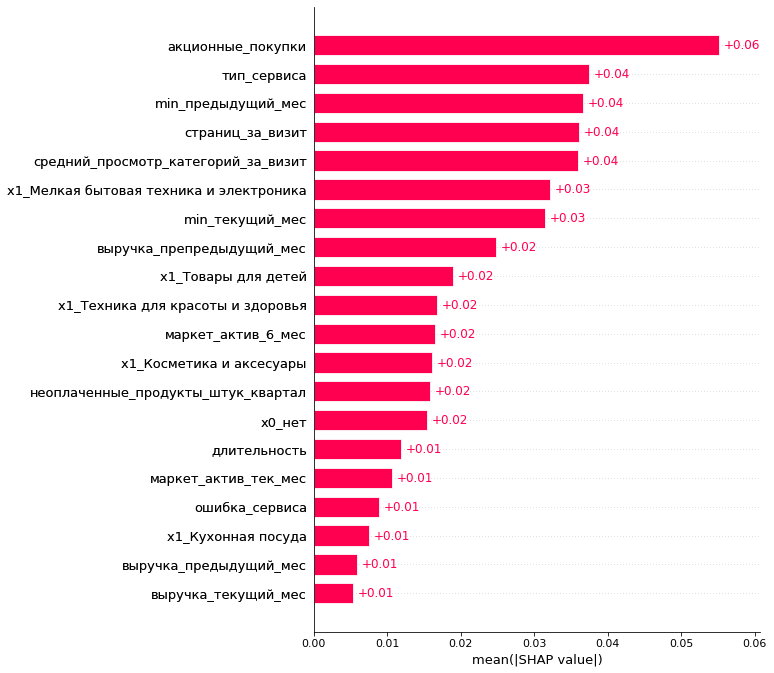

In [72]:
shap.plots.bar(shap_values[:,:,1], max_display = 21)

## Вывод:
  
    Малозначимые признаки:
        Выручка за предыдущий месяц
        Выручка за текущий месяц
        Кухонная посуда
        
    Значимые признаки:
        
        Акционные покупки
        Минуты провереденные на сайте в предыдущем месяце
        Тип сервиса
        
Компании следует обратить внимание на информирование об акциях на товары - акционные покупки значимая категория.
Так же важный признак - минут проведенные на сайте важны визуал и удобство сайта и полноту предоставляемой информации, наличие гиперссылок- так как чем больше пользователь
проводит времени на сайте, тем более он лоялен.
Тип сервиса один из важнейших пунктов- одной из задач можно поставить стимуляцию приобретения премиуп подписок.

## Сегментация покупателей

В данном разделе нам понадобятся данные о прибыльности покупателей из датасета data_money

In [73]:
predicted = randomized_search.predict_proba(X_test)[:, 1]
X_test['predicted'] = predicted
X_test.reset_index(inplace=True)
segment = X_test.merge(data_money, on = 'id')

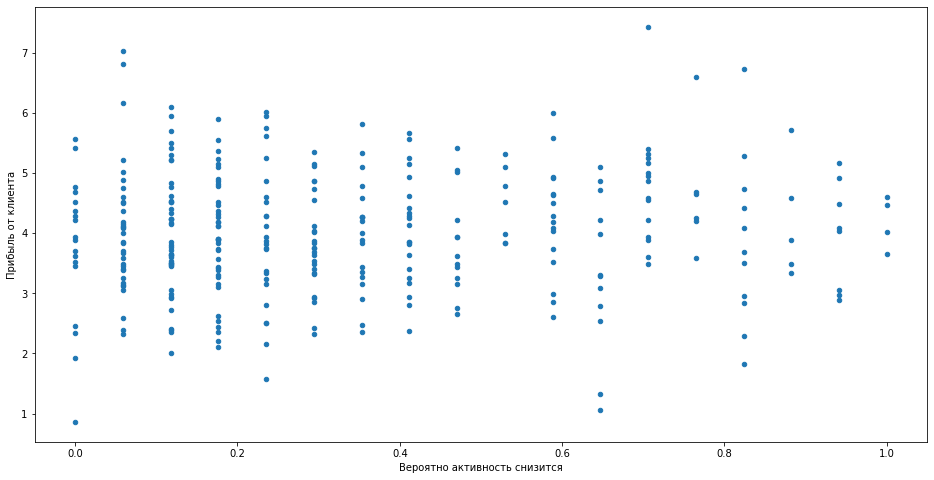

In [74]:
segment.plot.scatter(x = 'predicted', y = 'прибыль', figsize=(16, 8))
plt.xlabel('Вероятно активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

In [75]:
data_money.describe(percentiles=[0.1, 1/4, 1/2, 0.70, 0.95, 0.99])

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
10%,215477.900000,2.669000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
70%,216257.300000,4.550000
95%,216582.050000,5.580500
99%,216634.010000,6.400400


Рассмотрим тех, чья прибыль выше среднего, и вероятность снижения активности больше 0.5

In [76]:
segment = segment[(segment['predicted'] >= 0.5) & (segment['прибыль'] >= segment['прибыль'].mean())]

In [77]:
segment.drop('id', axis = 1).phik_matrix().style.background_gradient(cmap ='coolwarm')

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_мес', 'выручка_препредыдущий_мес', 'выручка_текущий_мес', 'min_предыдущий_мес', 'min_текущий_мес', 'predicted', 'прибыль']


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес,min_предыдущий_мес,min_текущий_мес,predicted,прибыль
тип_сервиса,1.000000,0.270031,0.000000,0.000000,0.251482,0.148210,0.388105,0.000000,0.326975,0.410528,0.610940,0.000000,0.344157,0.466446,0.074155,0.242480,0.000000,0.000000
разрешить_сообщать,0.270031,1.000000,0.000000,0.121730,0.212825,0.000000,0.000000,0.256373,0.296555,0.000000,0.355893,0.000000,0.365109,0.347378,0.422231,0.190146,0.229926,0.357220
маркет_актив_6_мес,0.000000,0.000000,1.000000,0.000000,0.383120,0.456650,0.209313,0.207028,0.000000,0.000000,0.275287,0.000000,0.462053,0.000000,0.000000,0.372507,0.000000,0.359169
маркет_актив_тек_мес,0.000000,0.121730,0.000000,1.000000,0.317492,0.284130,0.276086,0.585085,0.309248,0.000000,0.368105,0.543414,0.000000,0.000000,0.372087,0.392187,0.623317,0.000000
длительность,0.251482,0.212825,0.383120,0.317492,1.000000,0.398573,0.205287,0.000000,0.000000,0.000000,0.620628,0.000000,0.000000,0.482118,0.000000,0.204294,0.000000,0.000000
акционные_покупки,0.148210,0.000000,0.456650,0.284130,0.398573,1.000000,0.685853,0.209546,0.000000,0.000000,0.000000,0.280846,0.000000,0.155869,0.174109,0.000000,0.461581,0.000000
популярная_категория,0.388105,0.000000,0.209313,0.276086,0.205287,0.685853,1.000000,0.000000,0.444566,0.000000,0.000000,0.589123,0.000000,0.550081,0.457454,0.223466,0.446192,0.251196
средний_просмотр_категорий_за_визит,0.000000,0.256373,0.207028,0.585085,0.000000,0.209546,0.000000,1.000000,0.165052,0.000000,0.347799,0.000000,0.121503,0.000000,0.000000,0.248867,0.451875,0.000000
неоплаченные_продукты_штук_квартал,0.326975,0.296555,0.000000,0.309248,0.000000,0.000000,0.444566,0.165052,1.000000,0.000000,0.000000,0.000000,0.456257,0.000000,0.474102,0.000000,0.324845,0.000000
ошибка_сервиса,0.410528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.382880,0.000000,0.000000,0.000000,0.000000,0.000000,0.128930,0.217668


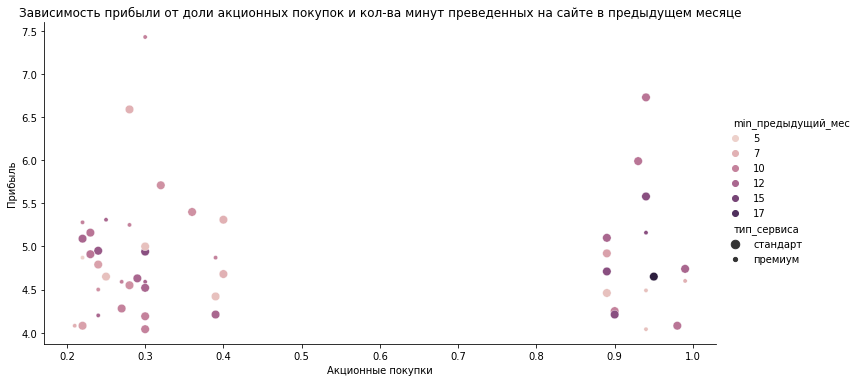

In [78]:
sn.relplot(data = segment, x = 'акционные_покупки', y ='прибыль', hue = 'min_предыдущий_мес', size = 'тип_сервиса', aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва минут преведенных на сайте в предыдущем месяце')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

5-12 минут наиболее популярны

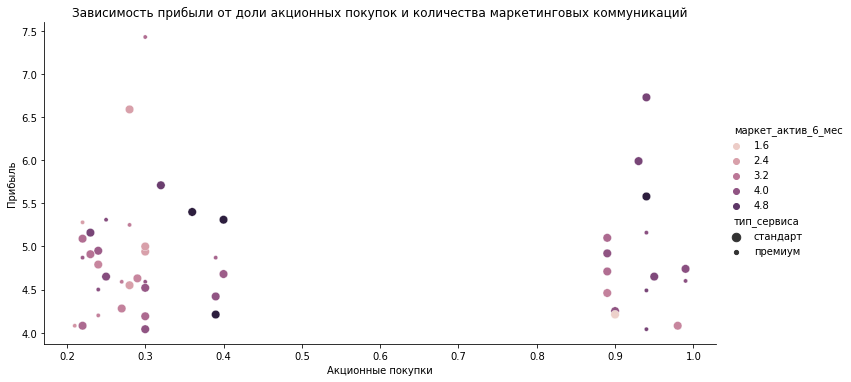

In [79]:
sn.relplot(data = segment, x = 'акционные_покупки', y ='прибыль', hue = 'маркет_актив_6_мес', size = 'тип_сервиса', aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и количества маркетинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

Премиум клиенты, далеко не основные потребители акционных товаров.

In [80]:
segment.pivot_table(index=[ 'страниц_за_визит', 'тип_сервиса']).sort_values(by = ['тип_сервиса'])


,,id,min_предыдущий_мес,min_текущий_мес,predicted,акционные_покупки,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес,длительность,маркет_актив_6_мес,маркет_актив_тек_мес,неоплаченные_продукты_штук_квартал,ошибка_сервиса,прибыль,средний_просмотр_категорий_за_визит
страниц_за_визит,тип_сервиса,,,,,,,,,,,,,,,
2,премиум,215609.000000,9.000000,9.000000,0.852941,0.590000,5771.250000,4831.500000,5772.550000,388.500000,3.700000,4.000000,8.500000,2.500000,4.345000,1.500000
3,премиум,215417.000000,9.000000,9.000000,0.588235,0.240000,3914.000000,4991.000000,3875.000000,377.000000,4.100000,5.000000,2.000000,2.000000,4.500000,3.000000
4,премиум,215560.000000,10.000000,9.500000,0.764706,0.260000,5454.750000,4546.500000,6088.500000,399.500000,2.900000,5.000000,4.500000,5.500000,6.355000,1.500000
5,премиум,215593.333333,9.333333,10.333333,0.764706,0.543333,5006.666667,4576.666667,5714.300000,930.666667,3.966667,4.333333,3.000000,5.333333,4.500000,2.666667
6,премиум,215556.666667,10.333333,9.000000,0.882353,0.736667,4937.666667,4435.666667,5736.733333,747.333333,3.766667,4.000000,4.333333,5.666667,5.003333,2.333333
7,премиум,215661.666667,7.333333,8.333333,0.803922,0.233333,4807.500000,4588.000000,5430.200000,905.000000,3.166667,3.666667,3.666667,3.666667,4.513333,2.333333
10,премиум,216244.000000,12.000000,16.000000,0.529412,0.250000,4573.000000,5047.000000,4292.200000,452.000000,4.200000,3.000000,2.000000,4.000000,5.310000,4.000000
1,стандарт,215488.666667,10.000000,7.333333,0.725490,0.526667,4945.500000,4588.333333,4721.900000,533.000000,4.166667,3.333333,5.000000,3.333333,4.396667,2.666667
2,стандарт,215580.800000,9.300000,9.000000,0.741176,0.503000,5049.800000,4537.100000,5140.280000,458.000000,3.780000,4.600000,3.300000,3.100000,4.871000,2.500000


Больше пользователей- большая вариативность проведенного на сайте времени.

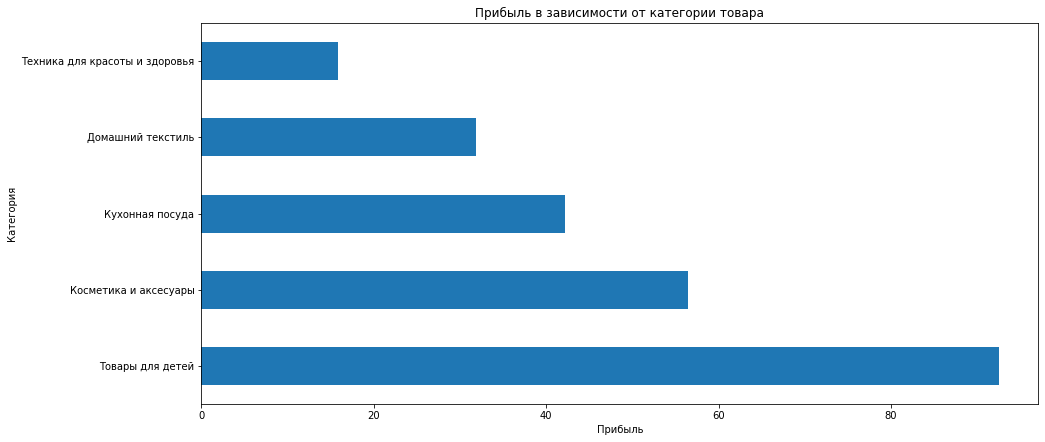

In [81]:
segment.groupby('популярная_категория')['прибыль'].sum().sort_values(ascending = False).plot(kind = 'barh', figsize = (15, 7))
plt.title('Прибыль в зависимости от категории товара')
plt.ylabel('Категория')
plt.xlabel('Прибыль')
plt.show()

Наибольшую прибыль приносит категория товаров для детей

In [82]:
segment.pivot_table(index=[ 'популярная_категория'])

,id,min_предыдущий_мес,min_текущий_мес,predicted,акционные_покупки,выручка_предыдущий_мес,выручка_препредыдущий_мес,выручка_текущий_мес,длительность,маркет_актив_6_мес,маркет_актив_тек_мес,неоплаченные_продукты_штук_квартал,ошибка_сервиса,прибыль,средний_просмотр_категорий_за_визит,страниц_за_визит
популярная_категория,,,,,,,,,,,,,,,,
Домашний текстиль,215501.571429,10.571429,7.571429,0.714286,0.535714,5391.642857,4593.857143,5631.771429,470.000000,3.642857,4.000000,4.428571,3.857143,4.555714,2.571429,3.000000
Косметика и аксесуары,215728.090909,10.545455,9.636364,0.727273,0.374545,5191.090909,4675.636364,5617.845455,651.545455,3.072727,4.090909,3.636364,4.000000,5.132727,2.363636,5.454545
Кухонная посуда,215660.111111,12.000000,10.444444,0.666667,0.514444,5203.611111,4549.444444,5533.233333,672.555556,3.722222,4.333333,5.555556,4.111111,4.683333,2.111111,4.666667
Техника для красоты и здоровья,215603.333333,12.333333,10.666667,0.627451,0.903333,3510.000000,4498.666667,4169.100000,718.000000,3.766667,4.000000,8.000000,4.666667,5.266667,2.333333,3.333333
Товары для детей,215624.736842,8.210526,9.421053,0.761610,0.480000,4727.500000,4609.421053,4993.726316,548.789474,4.042105,4.368421,3.105263,3.842105,4.867368,2.315789,3.894737


Итак:
    На основании вышеизложенного, мы видим что премиум клиенты довольно равнодушны к акционным предложениям
    Прибыль мало зависит от маркетинговой активности и времени на сайте
    Категории детских товаров и косметики имеют весьма скромные доли акционных покупок
    При этом пользователи проводящие мало времени на сайте и посещающие мало страниц за визит, имеют наибольшие вероятности на снижение активности.

Рекомендации:  
     Необходима разработка маркетинговых акций, направленых на представителей премиум сегмента
     Стоит обратить внимание на визуальное офорление сайта, наличие рекомендаций и ссылок - так как пользователи послещающие мало страниц наиболее расположены к снижению активности.
     Требуется популяризация разделов косметики и кухонной посуды - доля акционных покупок в них велика, но размер прибыли оставляет желать лучшего.
     

## Общий вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 
Целью исследования была разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

Данные были проверены на дубликаты и пропуски и очищены от них. Так же избавились от одного аномального значения выручки.
Для поиска лучшей модели был создан пайплайн в котором перебирались модели и гиперпараметры к ним.
Лучшая модель- модель ближайших соседей с количеством соседей 17.

Сделаны выводы, с предложениями для бизнеса:

 Так как акционные покупки, тип сервиса и время проведенное на сайте являются наиболее значимыми факторами для прибыли, следует избегать снижения внимания к этим категориям, и в то же время обратить внимание на категории товаров в которых 


На основании вышеизложенного, мы видим что премиум клиенты довольно равнодушны к акционным предложениям
    Прибыль мало зависит от маркетинговой активности и времени на сайте
    Категории детских товаров и косметики имеют весьма скромные доли акционных покупок
    При этом пользователи проводящие мало времени на сайте и посещающие мало страниц за визит, имеют наибольшие вероятности на снижение активности.

Рекомендации:  
     Необходима разработка маркетинговых акций, направленых на представителей премиум сегмента
     Стоит обратить внимание на визуальное офорление сайта, наличие рекомендаций и ссылок - так как пользователи послещающие мало страниц наиболее расположены к снижению активности.
     Требуется популяризация разделов косметики и кухонной посуды - доля акционных покупок в них велика, но размер прибыли оставляет желать лучшего.

